# Battery RUL - Phân tích dữ liệu & Tiền xử lý

Notebook này thực hiện phân tích dữ liệu khám phá (EDA), trực quan hóa và tiền xử lý dữ liệu cho bài toán dự đoán RUL của pin.

## 1. Import thư viện cần thiết

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

print("Thư viện đã import thành công!")

Thư viện đã import thành công!


## 2. Load dữ liệu và khám phá tổng quan

In [2]:
# Load dữ liệu
file_path = r"data/raw/Battery_RUL.csv"
df = pd.read_csv(file_path)

print("Kích thước dữ liệu:", df.shape)
print("Các cột dữ liệu:", list(df.columns))
df.head()
df.describe()

Kích thước dữ liệu: (15064, 9)
Các cột dữ liệu: ['Cycle_Index', 'Discharge Time (s)', 'Decrement 3.6-3.4V (s)', 'Max. Voltage Dischar. (V)', 'Min. Voltage Charg. (V)', 'Time at 4.15V (s)', 'Time constant current (s)', 'Charging time (s)', 'RUL']


,Cycle_Index,Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),Time constant current (s),Charging time (s),RUL
count,15064.000000,15064.000000,15064.000000,15064.000000,15064.000000,15064.000000,15064.000000,15064.000000,15064.000000
mean,556.155005,4581.273960,1239.784672,3.908176,3.577904,3768.336171,5461.266970,10066.496204,554.194172
std,322.378480,33144.012077,15039.589269,0.091003,0.123695,9129.552477,25155.845202,26415.354121,322.434514
min,1.000000,8.690000,-397645.908000,3.043000,3.022000,-113.584000,5.980000,5.980000,0.000000
25%,271.000000,1169.310000,319.600000,3.846000,3.488000,1828.884179,2564.310000,7841.922500,277.000000
50%,560.000000,1557.250000,439.239471,3.906000,3.574000,2930.203500,3824.260000,8320.415000,551.000000
75%,833.000000,1908.000000,600.000000,3.972000,3.663000,4088.326500,5012.350000,8763.282500,839.000000
max,1134.000000,958320.370000,406703.768000,4.363000,4.379000,245101.117000,880728.100000,880728.100000,1133.000000


## 3. Trực quan hóa dữ liệu ban đầu

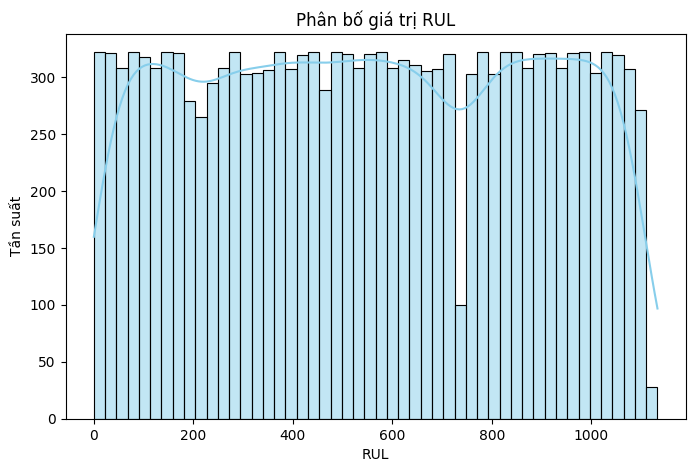

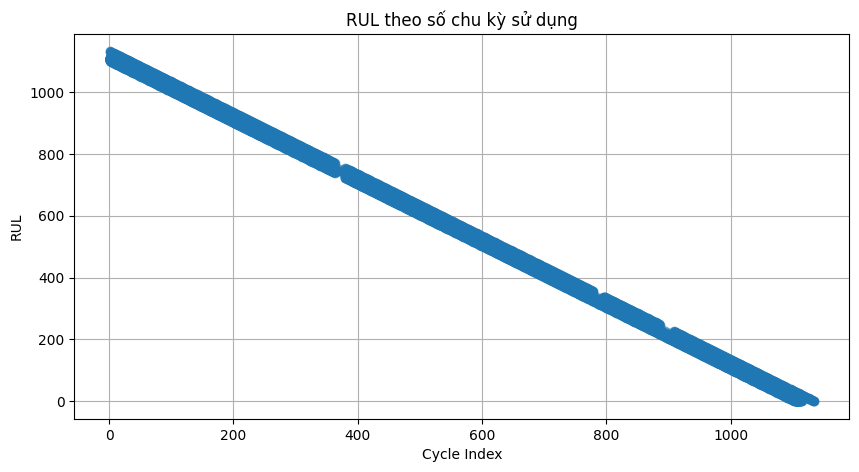

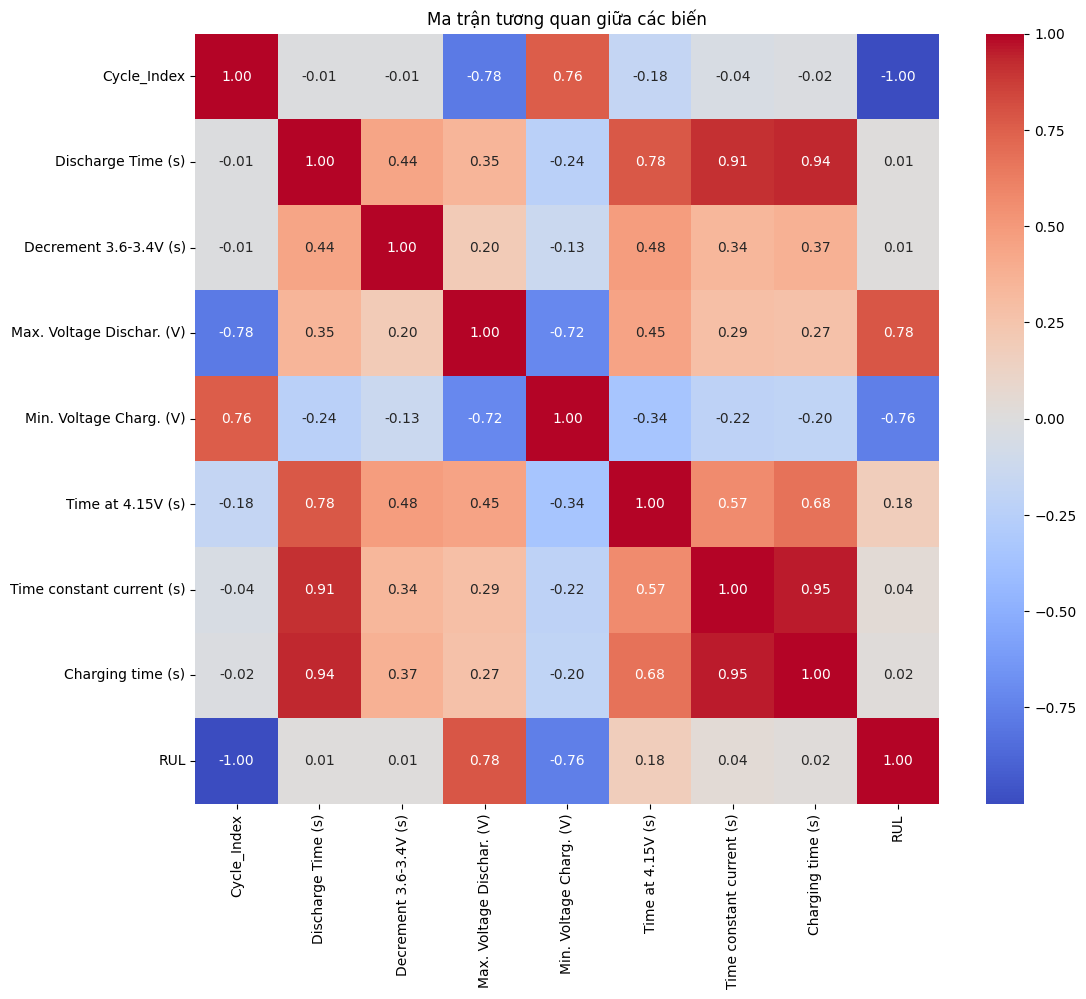

In [3]:
# Biểu đồ phân bố RUL
plt.figure(figsize=(8,5))
sns.histplot(df['RUL'], bins=50, kde=True, color='skyblue')
plt.title('Phân bố giá trị RUL')
plt.xlabel('RUL')
plt.ylabel('Tần suất')
plt.show()

# RUL theo chu kỳ
plt.figure(figsize=(10,5))
plt.plot(df['Cycle_Index'], df['RUL'], marker='o', linestyle='-', alpha=0.7)
plt.title('RUL theo số chu kỳ sử dụng')
plt.xlabel('Cycle Index')
plt.ylabel('RUL')
plt.grid(True)
plt.show()

# Ma trận tương quan
plt.figure(figsize=(12,10))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Ma trận tương quan giữa các biến')
plt.show()

## 4. Tiền xử lý dữ liệu

In [4]:
print('Missing values per column:')
print(df.isnull().sum())

# 1. Thời gian không thể âm hoặc bằng 0 (Time columns)
time_cols = [
    'Discharge Time (s)', 'Decrement 3.6-3.4V (s)',
    'Time at 4.15V (s)', 'Time constant current (s)', 'Charging time (s)'
]

for col in time_cols:
    # Thay thế giá trị <= 0 bằng NaN để xử lý sau (hoặc drop nếu muốn khắt khe)
    df.loc[df[col] <= 0, col] = np.nan

# 2. Xử lý các giá trị "siêu lớn" do lỗi cảm biến (Global Outliers)
# Thay vì clip, ta coi nó là NaN (mất dữ liệu) để nội suy lại.
# Ví dụ: Thời gian xả trung bình ~4500s, max lý thuyết khó vượt quá 15000s (trừ khi pin lạ).
# Ta dùng quantile cực đại (99.9%) để cắt bỏ phần đuôi quá vô lý mà không làm bẹt dữ liệu.
for col in time_cols:
    upper_limit = df[col].quantile(0.995) # Chỉ cắt 0.5% dữ liệu cao nhất (thường là nhiễu cực đoan)
    df.loc[df[col] > upper_limit, col] = np.nan

# --- BƯỚC 2: XỬ LÝ BẰNG TÍNH LIÊN TỤC (TIME SERIES SMOOTHING) ---
# Vì pin chai dần theo thời gian (Cycle_Index), dữ liệu phải mượt.
# Ta sắp xếp theo Cycle_Index để đảm bảo thứ tự
df = df.sort_values('Cycle_Index')

# Hàm lọc nhiễu cục bộ (Local Outlier) bằng Rolling Median
# Nếu giá trị hiện tại lệch quá xa so với trung vị của 5 chu kỳ gần nhất -> Coi là nhiễu
def filter_local_outliers(df, cols, window=5, threshold=0.5):
    df_clean = df.copy()
    for col in cols:
        # Tính trung vị trượt (Rolling Median)
        rolling_med = df_clean[col].rolling(window=window, center=True).median()
        
        # Tính độ lệch tương đối
        deviation = np.abs(df_clean[col] - rolling_med) / rolling_med
        
        # Nếu lệch quá threshold (ví dụ 50%), gán NaN
        mask = deviation > threshold
        df_clean.loc[mask, col] = np.nan
        print(f"Cột {col}: Đã loại bỏ {mask.sum()} điểm dữ liệu bất thường cục bộ.")
        
    return df_clean

# Áp dụng lọc cục bộ
feature_cols = [col for col in df.columns if col not in ['RUL', 'Cycle_Index']]
df_clean = filter_local_outliers(df, feature_cols, window=10, threshold=0.3)

# --- BƯỚC 3: ĐIỀN DỮ LIỆU (INTERPOLATION) ---
# Với dữ liệu chuỗi thời gian, Interpolate (nội suy tuyến tính) tốt hơn Fillna(Mean/Median)
# Nó sẽ nối điểm trước và điểm sau để điền vào chỗ trống, tạo ra đường cong mượt mà.
df_final = df_clean.interpolate(method='linear', limit_direction='both')

# --- KIỂM TRA KẾT QUẢ ---
print(f"\nKích thước sau xử lý: {df_final.shape}")
print("\nThống kê mô tả sau khi làm sạch (hợp lý hơn):")
df_final[feature_cols].describe()

Missing values per column:
Cycle_Index                  0
Discharge Time (s)           0
Decrement 3.6-3.4V (s)       0
Max. Voltage Dischar. (V)    0
Min. Voltage Charg. (V)      0
Time at 4.15V (s)            0
Time constant current (s)    0
Charging time (s)            0
RUL                          0
dtype: int64
Cột Discharge Time (s): Đã loại bỏ 114 điểm dữ liệu bất thường cục bộ.
Cột Decrement 3.6-3.4V (s): Đã loại bỏ 52 điểm dữ liệu bất thường cục bộ.
Cột Max. Voltage Dischar. (V): Đã loại bỏ 0 điểm dữ liệu bất thường cục bộ.
Cột Min. Voltage Charg. (V): Đã loại bỏ 0 điểm dữ liệu bất thường cục bộ.
Cột Time at 4.15V (s): Đã loại bỏ 243 điểm dữ liệu bất thường cục bộ.
Cột Time constant current (s): Đã loại bỏ 205 điểm dữ liệu bất thường cục bộ.
Cột Charging time (s): Đã loại bỏ 158 điểm dữ liệu bất thường cục bộ.

Kích thước sau xử lý: (15064, 9)

Thống kê mô tả sau khi làm sạch (hợp lý hơn):


,Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),Time constant current (s),Charging time (s)
count,15064.000000,15064.000000,15064.000000,15064.000000,15064.000000,15064.000000,15064.000000
mean,2431.494567,522.232835,3.908176,3.577904,3215.651277,4146.187166,8641.906719
std,11948.500108,1436.811036,0.091003,0.123695,3675.177157,4755.914947,4476.833081
min,34.380000,38.709677,3.043000,3.022000,255.241143,8.000000,8.380000
25%,1168.717500,320.000000,3.846000,3.488000,1834.027286,2564.310000,7837.535000
50%,1555.380000,438.857143,3.906000,3.574000,2924.359000,3788.380000,8313.235000
75%,1906.675000,598.400000,3.972000,3.663000,4076.344000,5012.320000,8756.360000
max,197940.480000,86584.925500,4.363000,4.379000,62910.013000,78270.020000,78660.000000


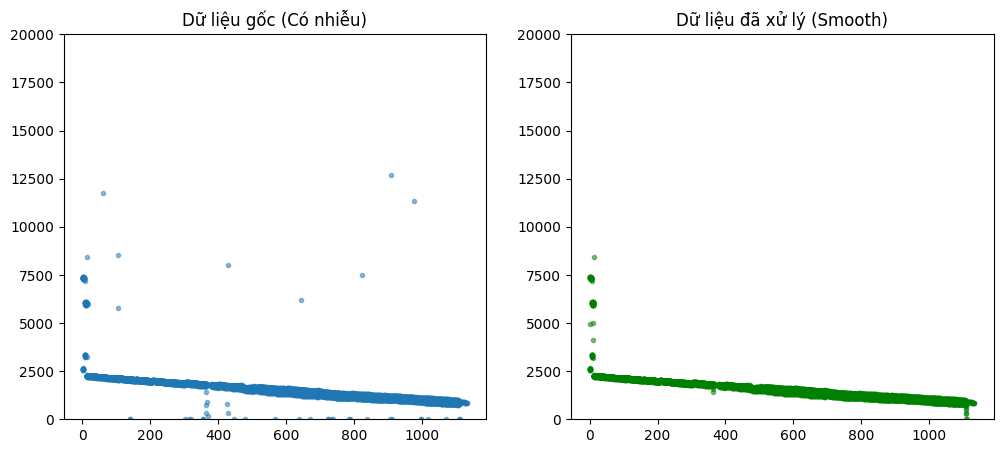

In [5]:
# Vẽ biểu đồ so sánh nhanh
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("Dữ liệu gốc (Có nhiễu)")
plt.plot(df['Cycle_Index'], df['Discharge Time (s)'], '.', alpha=0.5)
plt.ylim(0, 20000) # Zoom vào vùng hợp lý để thấy nhiễu

plt.subplot(1, 2, 2)
plt.title("Dữ liệu đã xử lý (Smooth)")
plt.plot(df_final['Cycle_Index'], df_final['Discharge Time (s)'], '.', color='green', alpha=0.5)
plt.ylim(0, 20000)
plt.show()

df_final.to_csv('data/processed/Battery_RUL_processed.csv', index=False)